In [1]:
from simple_exact_diagonalization_routines.local_matrix_class import *
from scipy.linalg import expm
from scipy import optimize
from scipy import signal
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from class_double_bracket_flow import *

In [2]:
# Computation of nth Gamma function i.e [W,...,[W,[W,H]]...]
def gamma(H, n, D):
    flow = double_bracket_flow(H)
    if n == 0:
        return H
    else:
        W = flow.commutator(flow.delta(D),flow.sigma(H))
        result = H
        for i in range(n):
            result = flow.commutator(W,result)
    return result

# Polynomial approximation of the square norm function using Baker-Campbell-Hausdorff formula
def normApproximation(H,n,s):
    # approx = HS(e^sH)^2
    order = np.empty((n+1,np.shape(H)[0],np.shape(H)[1]))
    approx = 0
    flow = double_bracket_flow(H)
    for i in range(n+1):
        order[i] = s**i/np.math.factorial(i)*gamma(H,i)
    for i in range(n+1):
        for j in range(n+1):
            if i+j <= n:
                approx += HS(flow.sigma(order[i]),flow.sigma(order[j]))
    return approx

# Tranverse field Ising model
def H_TFIM(L):
    X = X_class(L)
    Y = Y_class(L)
    Z = Z_class(L)
    S_plus = S_plus_class(L)
    S_minus = S_minus_class(L)
    H_TFIM = 0*np.eye( 2**L ) 

    for x in range(L-1):
        H_TFIM = H_TFIM + 2*X.at(x+1).dot(X.at(x+2)) + Z.at(x+1)
    H_TFIM = H_TFIM + Z.at(L)    
    return H_TFIM

# Transverse field Ising model with longitudinal field
def H_TLFIM(L):
    X = X_class(L)
    Y = Y_class(L)
    Z = Z_class(L)
    S_plus = S_plus_class(L)
    S_minus = S_minus_class(L)
    H_TLFIM = 0*np.eye( 2**L ) 

    for x in range(L-1):
        H_TLFIM = H_TLFIM + 2*X.at(x+1).dot(X.at(x+2)) + Z.at(x+1)+ X.at(x+1)
    H_TLFIM = H_TLFIM + Z.at(L)    + X.at(L) 
    
    return H_TLFIM


In [3]:
# Compute the partial derivative of Gamma_n of the ith diagonal element of D
def dGamma_di(D, H, n, i):
    A = np.zeros(D.shape)
    A[i,i] = 1
    flow = double_bracket_flow(H)
    if n == 0:
        return 0
    elif n == 1:
        return flow.commutator(A,H)
    else:
        B = flow.commutator(flow.commutator(A,H),gamma(H,n-1,D))
        W = flow.commutator(D,H)
        return B + flow.commutator(W,dGamma_di(D,H,n-1,i))

# Compute coefficients of the third order approximation of the off-diagonal norm
def polynomialCoefficients(D,H):
    flow = double_bracket_flow(H)

    a = np.trace(3*flow.sigma(gamma(H,1,D))@flow.sigma(gamma(H,2,D)))
    a += np.trace(flow.sigma(gamma(H,0,D))@flow.sigma(gamma(H,3,D)))

    b = 2*np.trace(flow.sigma(gamma(H,1,D))@flow.sigma(gamma(H,1,D)))
    b += 2*np.trace(flow.sigma(gamma(H,0,D))@flow.sigma(gamma(H,2,D)))

    c = 2*np.trace(flow.sigma(gamma(H,0,D))@flow.sigma(gamma(H,1,D)))
    return a,b,c

# s step that minimizes the third order approximation    
def s_min(D,H):
    flow = double_bracket_flow(H)

    a = np.trace(3*flow.sigma(gamma(H,1,D))@flow.sigma(gamma(H,2,D)))
    a += np.trace(flow.sigma(gamma(H,0,D))@flow.sigma(gamma(H,3,D)))

    b = 2*np.trace(flow.sigma(gamma(H,1,D))@flow.sigma(gamma(H,1,D)))
    b += 2*np.trace(flow.sigma(gamma(H,0,D))@flow.sigma(gamma(H,2,D)))

    c = 2*np.trace(flow.sigma(gamma(H,0,D))@flow.sigma(gamma(H,1,D)))

    delta = b**2 - 4*a*c

    s = (-b+np.sqrt(delta))/(2*a)
    # s_minus always negative
    return s
    
# Partial derivative of s_min with respect to the ith diagonal element of D (note: that the minimum time-step depends on D so we also need to derivate)
def ds_di(D,H,i,a,b,c):
    flow = double_bracket_flow(H)

    da = np.trace(3*flow.sigma(dGamma_di(D,H,1,i))@flow.sigma(gamma(H,2,D)))
    da += np.trace(3*flow.sigma(dGamma_di(D,H,2,i))@flow.sigma(gamma(H,1,D)))
    da += np.trace(3*flow.sigma(dGamma_di(D,H,3,i))@flow.sigma(gamma(H,0,D)))

    db = 4*np.trace(flow.sigma(dGamma_di(D,H,1,i))@flow.sigma(gamma(H,1,D)))
    db += 2*np.trace(flow.sigma(dGamma_di(D,H,2,i))@flow.sigma(gamma(H,0,D)))


    dc = 2*np.trace(flow.sigma(dGamma_di(D,H,1,i))@flow.sigma(gamma(H,0,D)))

    delta = b**2 - 4*a*c
    ddelta = 2*(b*db - 2*(a*dc+da*c))

    ds = 2*((-db+0.5*ddelta/np.sqrt(delta))*a+(-b+np.sqrt(delta))*da)
    ds /= 4*a**2

    return ds,da,db,dc


# Gradient with lagrange multiplier
def gradient(D,H,s,lagrange):
    grad = np.zeros(len(D)+2)
    a,b,c = polynomialCoefficients(D,H)
    for i in range(len(D)):
        ds,da,db,dc = ds_di(D,H,i,a,b,c)
        grad[i] = s**3/3*da+s**2/2*db+2*s*dc-lagrange*ds
    grad[-2] = s**2*a+s*b+2*c+lagrange
    grad[-1] = s-s_min(D,H)
    return grad

# Gradient descent algorithm (note: that the learning rate is different for the time-step to improve stability)
def gradient_descent(D,lagrange,H,iters=1000, lr=1e-2):
    loss = np.zeros(iters+1)
    flow = double_bracket_flow(H)
    W = flow.commutator(flow.delta(D),flow.sigma(H))
    s = s_min(D,H)
    loss[0] = np.linalg.norm(flow.sigma(expm(s*W)@H@expm(-s*W)))
    for i in range(iters):
        grad = gradient(D,H,s,lagrange)
        for j in range(D.shape[0]):  
            D[j,j] = D[j,j] - lr*grad[j]
        s = s-0.01*lr*grad[-2]
        # Note also that we ascend for the lagrange multiplier as the wanted point is a saddle-point
        lagrange = lagrange + lr*grad[-1]
        W = flow.commutator(flow.delta(D),flow.sigma(H))
        smin = s_min(D,H)
        loss[i+1] = np.linalg.norm(flow.sigma(expm(smin*W)@H@expm(-smin*W)))

        # Learning may increase the norm a lot, in that case we stop
        if loss[i+1] > loss[i] + 0.1:
           break
    loss2 = loss[0:i+1]
    s = s_min(D,H)
    return D,s,loss2,lagrange

# Optimal flow with variational D
def optimalEvolution(H,steps,lr=1e-4):
    flow = double_bracket_flow(H)
    norm_sigma = np.empty(steps+1)
    norm_sigma[0] = np.linalg.norm(flow.sigma(H))
    total_flow = 0
    for i in tqdm(range(steps)):
        D = flow.delta(H)
        lagrange = 1
        D,s,loss,lagrange = gradient_descent(D,lagrange,H,lr=lr)
        W = flow.commutator(flow.delta(D),flow.sigma(H))
        norm_sigma[i+1] = np.linalg.norm(flow.sigma(expm(s*W)@H@expm(-s*W)))
        H = expm(s*W)@H@expm(-s*W)
        total_flow += s
    return norm_sigma,H,total_flow


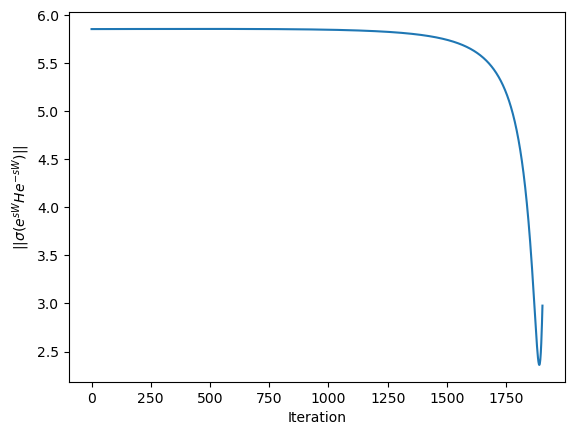

In [10]:
# Initial Learning
L = 3
H = H_TFIM(L)
iters = 200
lr = 1e-4
flow = double_bracket_flow(H)
D = flow.delta(H)
lagrange = 1
W = flow.commutator(flow.delta(H),flow.sigma(H))
D,s,loss,lagrange = gradient_descent(D,lagrange,H,iters, lr)
plt.figure()
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')
plt.show()

# Flow using Gradient Descent
H = H_TFIM(L)
# norms, H, total_flow = optimalEvolution(H,20,lr=lr)
# plt.figure()
# plt.plot(norms)
# plt.xlabel('Iteration')
# plt.ylabel(r'$|| \sigma(H_t) || $')


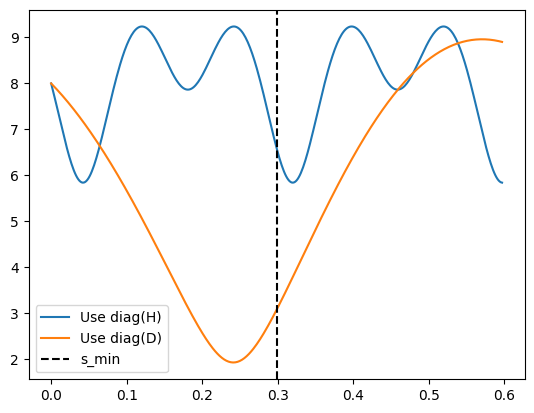

In [38]:
# How the landscape looks like for the initial H and after finding best D
L = 3
H = H_TFIM(L)
iters = 2000
D = flow.delta(H)
flow = double_bracket_flow(H)
lagrange = 1
D,s,loss,L = gradient_descent(D,lagrange,H,iters,lr=1e-4)
s2 = s_min(D,H)
flow_times = np.linspace(0,2*s2,400)
sigma_H = np.empty((len(flow_times)))
sigma_D = np.empty((len(flow_times)))


for steps in range(len(flow_times)):
    W = flow.commutator(flow.delta(H),flow.sigma(H))
    sigma_H[steps] = np.linalg.norm(flow.sigma(expm(flow_times[steps]*W)@H@expm(-flow_times[steps]*W)))
    W = flow.commutator(flow.delta(D),flow.sigma(H))
    sigma_D[steps] = np.linalg.norm(flow.sigma(expm(flow_times[steps]*W)@H@expm(-flow_times[steps]*W)))

plt.figure()
plt.plot(flow_times,sigma_H,label='Use diag(H)')
plt.plot(flow_times,sigma_D,label='Use diag(D)')
plt.axvline(x=s2,color='black',linestyle='--', label=r'$s_{min}$')
plt.legend()

In [40]:
# This gradient minimizes the just the norm at the given s
def gradient2(D,H):
    grad = np.zeros(len(D))
    a,b,c = polynomialCoefficients(D,H)
    s = s_min(D,H)
    for i in range(len(D)):
        ds,da,db,dc = ds_di(D,H,i,a,b,c)
        grad[i] = s**3/3*da+s**2/2*db+2*s*dc+s**2*ds*a+s*ds*b+2*ds*c
    return grad,s

# Gradient descent algorithm
def gradient_descent2(D, H,iters=1000, lr=1e-2):
    loss = np.zeros(iters+1)
    flow = double_bracket_flow(H)
    W = flow.commutator(flow.delta(D),flow.sigma(H))
    s = s_min(D,H)
    loss[0] = np.linalg.norm(flow.sigma(expm(s*W)@H@expm(-s*W)))
    for i in range(iters):
        grad,s = gradient2(D,H)
        for j in range(D.shape[0]):  
            D[j,j] = D[j,j] - lr*grad[j]
        W = flow.commutator(flow.delta(D),flow.sigma(H))
        loss[i+1] = np.linalg.norm(flow.sigma(expm(s*W)@H@expm(-s*W)))

        if loss[i] > (loss[i-1]+0.1) and i > 0:
            break
        loss2 = loss[0:i]
 
    return D,s,loss2

# Flow using Gradient Descent
def optimalEvolution2(H,steps,lr=1e-2):
    norm_sigma = np.empty(steps+1)
    norm_sigma[0] = np.linalg.norm(flow.sigma(H))
    total_flow = 0
    for i in tqdm(range(steps)):
        D = flow.delta(H)
        D,s,loss = gradient_descent2(D,H,lr=lr)
        W = flow.commutator(flow.delta(D),flow.sigma(H))
        norm_sigma[i+1] = np.linalg.norm(flow.sigma(expm(s*W)@H@expm(-s*W)))
        H = expm(s*W)@H@expm(-s*W)
        total_flow += s
    return norm_sigma,H,total_flow

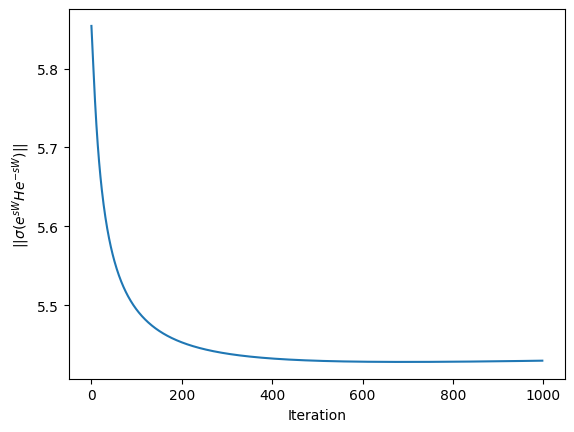

In [34]:
L = 3
H = H_TFIM(L)
iters = 1000
lr = 1e-2
flow = double_bracket_flow(H)
D = flow.delta(H)

W = flow.commutator(flow.delta(H),flow.sigma(H))
D,s,loss = gradient_descent2(D,H,iters, lr)
plt.figure()
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')
plt.show()


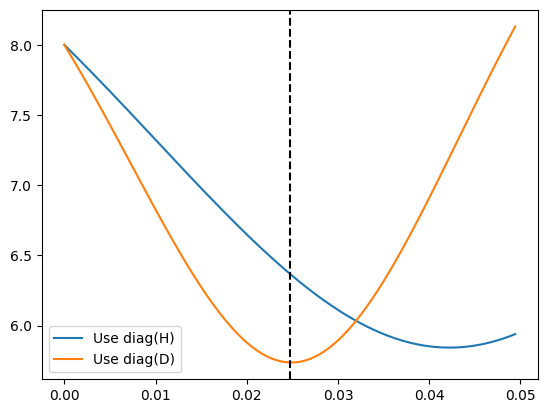

In [37]:
L = 3
H = H_TFIM(L)
iters = 100
D = flow.delta(H)
flow = double_bracket_flow(H)
D,s,loss = gradient_descent2(D,H,iters,lr=1e-3)
s2 = s_min(D,H)
flow_times = np.linspace(0,2*s2,400)
sigma_H = np.empty((len(flow_times)))
sigma_D = np.empty((len(flow_times)))


for steps in range(len(flow_times)):
    W = flow.commutator(flow.delta(H),flow.sigma(H))
    sigma_H[steps] = np.linalg.norm(flow.sigma(expm(flow_times[steps]*W)@H@expm(-flow_times[steps]*W)))
    W = flow.commutator(flow.delta(D),flow.sigma(H))
    sigma_D[steps] = np.linalg.norm(flow.sigma(expm(flow_times[steps]*W)@H@expm(-flow_times[steps]*W)))

plt.figure()
plt.plot(flow_times,sigma_H,label='Use diag(H)')
plt.plot(flow_times,sigma_D,label='Use diag(D)')
plt.axvline(x=s,color='black',linestyle='--',label = r'$s_{min}$')
plt.legend()


100%|██████████| 15/15 [01:00<00:00,  4.05s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


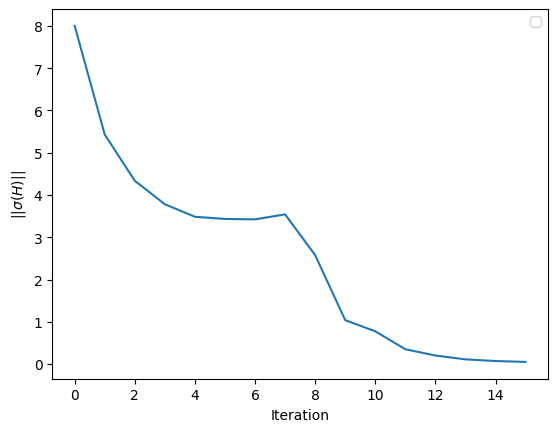

In [43]:
L = 3
H = H_TFIM(L)
norm,H_final,total_flow = optimalEvolution2(H,15)
plt.figure()
plt.plot(norm)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(H) || $')
plt.legend()

In [51]:
# Compute the gradient of the norm without also parametrizing the s
def gradient3(D,H):
    grad = np.zeros(len(D)+1)
    a,b,c = polynomialCoefficients(D,H)
    s = s_min(D,H)
    for i in range(len(D)):
        ds,da,db,dc = ds_di(D,H,i,a,b,c)
        grad[i] = s**3/3*da+s**2*db+2*s*dc
    return grad,s

# Gradient descent algorithm
def gradient_descent3(D,H,iters=500, lr=1e-2):
    loss = np.zeros(iters+1)
    flow = double_bracket_flow(H)
    W = flow.commutator(flow.delta(D),flow.sigma(H))
    s = s_min(D,H)
    loss[0] = np.linalg.norm(flow.sigma(expm(s*W)@H@expm(-s*W)))
    for i in range(iters):
        grad,s = gradient3(D,H)
        for j in range(D.shape[0]):  
            D[j,j] = D[j,j] - lr*grad[j]
        W = flow.commutator(flow.delta(D),flow.sigma(H))
        loss[i+1] = np.linalg.norm(flow.sigma(expm(s*W)@H@expm(-s*W)))

        if loss[i] > (loss[i-1]+0.001) and i > 0:
            break
    loss2 = loss[0:i]

    return D,s,loss2

# Flow using Gradient Descent
def optimalEvolution3(H,steps,lr=1e-2):
    norm_sigma = np.empty(steps+1)
    norm_sigma[0] = np.linalg.norm(flow.sigma(H))
    total_flow = 0
    for i in tqdm(range(steps)):
        D = flow.delta(H)
       
        D,s,loss = gradient_descent3(D,H,lr=lr)
        W = flow.commutator(flow.delta(D),flow.sigma(H))
        norm_sigma[i+1] = np.linalg.norm(flow.sigma(expm(s*W)@H@expm(-s*W)))
        H = expm(s*W)@H@expm(-s*W)
        total_flow += s
    return norm_sigma,H,total_flow

In [7]:
L = 3
H = H_TFIM(L)
iters = 2000
lr = 1e-2
flow = double_bracket_flow(H)

D = flow.delta(H)
W = flow.commutator(flow.delta(H),flow.sigma(H))
D,s,loss= gradient_descent3(D,H,iters, lr)

plt.figure()
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')
plt.show()

L = 3
H = H_TFIM(L)
norm,H_final,total_flow = optimalEvolution3(H,20)
plt.figure()
plt.plot(norm,label = 'Using variational D')
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(H) || $')
plt.legend()

NameError: name 'gradient_descent3' is not defined

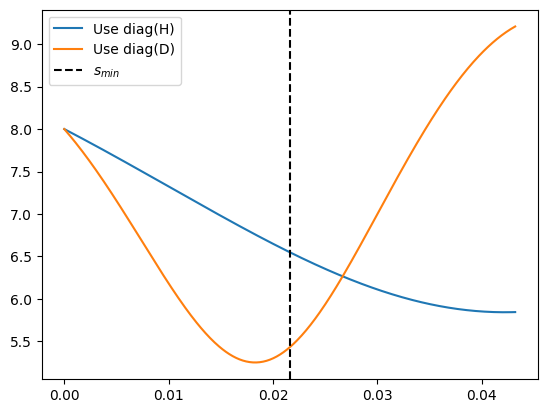

In [54]:
L = 3
H = H_TFIM(L)
iters = 1000
D = flow.delta(H)
flow = double_bracket_flow(H)
D,s,loss = gradient_descent3(D,H,iters,lr)
s = s_min(D,H)
flow_times = np.linspace(0,2*s,400)
sigma_H = np.empty((len(flow_times)))
sigma_D = np.empty((len(flow_times)))


for steps in range(len(flow_times)):
    W = flow.commutator(flow.delta(H),flow.sigma(H))
    sigma_H[steps] = np.linalg.norm(flow.sigma(expm(flow_times[steps]*W)@H@expm(-flow_times[steps]*W)))
    W = flow.commutator(flow.delta(D),flow.sigma(H))
    sigma_D[steps] = np.linalg.norm(flow.sigma(expm(flow_times[steps]*W)@H@expm(-flow_times[steps]*W)))

plt.figure()
plt.plot(flow_times,sigma_H,label='Use diag(H)')
plt.plot(flow_times,sigma_D,label='Use diag(D)')
plt.axvline(x=s,color='black',linestyle='--',label = r'$s_{min}$')
plt.legend()